In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

import wget

import matplotlib.pyplot as plt
import librosa.display

import zipfile
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from io import TextIOWrapper

from tqdm import tqdm
import requests


from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from scipy.signal import hilbert


import random
from scipy.signal import fftconvolve

from scipy.signal import hilbert
import numpy as np
import librosa
from tqdm import tqdm

In [2]:
# ----------------------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------
# DATASET IMPORT, EXTRACTION, ANALYSIS
# ----------------------------------------------------------------------------------

def extract_zip_if_needed(zip_path, extract_to=None):
    """
    Estrae il file ZIP se la cartella di destinazione non esiste già.

    Args:
        zip_path (str): Percorso al file ZIP
        extract_to (str, optional): Cartella dove estrarre i file. Se None, usa il nome del file ZIP.

    Returns:
        str: Percorso alla cartella estratta
    """

    # Se la directory di estrazione non è specificata, usa il nome del file ZIP
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Controlla se la directory di estrazione esiste già
    if os.path.exists(extract_to) and os.path.isdir(extract_to):
        print(f"La directory '{extract_to}' esiste già, l'estrazione verrà saltata.")
        return extract_to

    # Estrai lo ZIP se esiste
    if os.path.exists(zip_path):
        print(f"Estrazione di '{zip_path}' in '{extract_to}'...")

        # Ottieni la lista dei file nello ZIP per la progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            total_files = len(file_list)

        # Estrai i file con progress bar
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            os.makedirs(extract_to, exist_ok=True)
            for file in tqdm(file_list, desc="Estrazione files", total=total_files):
                zip_ref.extract(file, extract_to)

        print(f"Estrazione completata in '{extract_to}'")
    else:
        raise FileNotFoundError(f"Il file ZIP '{zip_path}' non esiste.")

    return extract_to



def import_idmt_traffic_dataset(fn_txt: str = "idmt_traffic_all") -> pd.DataFrame:
    """ Import IDMT-Traffic dataset
    Args:
        fn_txt (str): Text file with all WAV files
    Returns:
        df_dataset (pd.Dataframe): File-wise metadata
            Columns:
                'file': WAV filename,
                'is_background': True if recording contains background noise (no vehicle), False else
                'date_time': Recording time (YYYY-MM-DD-HH-mm)
                'location': Recording location
                'speed_kmh': Speed limit at recording site (km/h), UNK if unknown,
                'sample_pos': Sample position (centered) within the original audio recording,
                'daytime': M(orning) or (A)fternoon,
                'weather': (D)ry or (W)et road condition,
                'vehicle': (B)us, (C)ar, (M)otorcycle, or (T)ruck,
                'source_direction': Source direction of passing vehicle: from (L)eft or from (R)ight,
                'microphone': (SE)= (high-quality) sE8 microphones, (ME) = (low-quality) MEMS microphones (ICS-43434),
                'channel': Original stereo pair channel (12) or (34)
    """

    df_files = pd.read_csv(fn_txt, names=('file',))
    fn_file_list = df_files['file'].to_list()

    df_dataset = []

    for f, fn in enumerate(fn_file_list):
        fn = fn.replace('.wav', '')
        parts = fn.split('_')

        # background noise files
        if '-BG' in fn:
            date_time, location, speed_kmh, sample_pos, mic, channel = parts
            vehicle, source_direction, weather, daytime = 'None', 'None', 'None', 'None'
            is_background = True

        # files with vehicle passings
        else:
            date_time, location, speed_kmh, sample_pos, daytime, weather, vehicle_direction, mic, channel = parts
            vehicle, source_direction = vehicle_direction
            is_background = False

        channel = channel.replace('-BG', '')
        speed_kmh = speed_kmh.replace('unknownKmh', 'UNK')
        speed_kmh = speed_kmh.replace('Kmh', '')

        df_dataset.append({'file': fn,
                           'is_background': is_background,
                           'date_time': date_time,
                           'location': location,
                           'speed_kmh': speed_kmh,
                           'sample_pos': sample_pos,
                           'daytime': daytime,
                           'weather': weather,
                           'vehicle': vehicle,
                           'source_direction': source_direction,
                           'microphone': mic,
                           'channel': channel})

    df_dataset = pd.DataFrame(df_dataset, columns=('file', 'is_background', 'date_time', 'location', 'speed_kmh', 'sample_pos', 'daytime', 'weather', 'vehicle',
                                                   'source_direction', 'microphone', 'channel'))

    return df_dataset

def analyze_audio_channels(file_list):
    """
    Analizza il numero di canali audio nei file del database.

    Args:
        file_list: Lista di percorsi ai file audio

    Returns:
        tuple: (conteggio_stereo, conteggio_mono, dettagli_per_file)
    """
    mono_count = 0
    stereo_count = 0
    file_details = []

    # Loop attraverso tutti i file con progress bar
    for file_path in tqdm(file_list, desc="Analisi file audio"):
        try:
            # Carica il file preservando i canali
            y, sr = librosa.load(file_path, sr=None, mono=False)

            # Controlla se è mono o stereo
            if y.ndim == 1:  # Mono (1 dimensione)
                mono_count += 1
                channels = 1
            else:  # Stereo (2 dimensioni)
                stereo_count += 1
                channels = y.shape[0]

            # Aggiungi dettagli
            file_name = os.path.basename(file_path)
            file_details.append({
                'file': file_name,
                'channels': channels,
                'tipo': 'mono' if channels == 1 else 'stereo'
            })

        except Exception as e:
            print(f"Errore nell'analisi del file {file_path}: {e}")

    return stereo_count, mono_count, file_details


# ----------------------------------------------------------------------
# DATA AUGMENTATION
# ----------------------------------------------------------------------

# 1. Rumore
def add_noise(y, snr_db=10):
    signal_power = np.mean(y**2)
    snr = 10**(snr_db / 10)
    noise_power = signal_power / snr
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

# 2. Pitch shift

def apply_pitch_shift(y, sr):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.pitch_shift(y[0], sr=sr, n_steps=2)
        ch2 = librosa.effects.pitch_shift(y[1], sr=sr, n_steps=2)
        
        # Ricombina i canali
        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

# 3. Time stretch

def apply_time_stretch(y, rate=1.2):
    is_stereo = y.ndim > 1
    
    if is_stereo:
        # Gestione stereo (separatamente per ogni canale)
        ch1 = librosa.effects.time_stretch(y[0], rate=rate)
        ch2 = librosa.effects.time_stretch(y[1], rate=rate)
        
        if len(ch1) > len(y[0]):
            ch1 = ch1[:len(y[0])]
        elif len(ch1) < len(y[0]):
            ch1= np.pad(ch1, (0, len(y[0])-len(ch1)), mode='constant', constant_values=(0,0))

        if len(ch2) > len(y[1]):
            ch2 = ch2[:len(y[1])]
        elif len(ch2) < len(y[1]):
            ch2 = np.pad(ch2, (0, len(y[1])-len(ch2)), mode='constant', constant_values=(0,0))
        
        # print(len(y[0]))
        # print(len(y[1]))
        # print(len(ch1))
        # print(len(ch2))

        return np.array([ch1, ch2])
    else:
        # Caso mono originale
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        if len(y_stretched) > len(y):
            return y_stretched[:len(y)]
        else:
            return np.pad(y_stretched, (0, len(y) - len(y_stretched)), mode='constant')

'''
def apply_random_crop(y, sr, target_duration=2.0):
    # Rileva se l'audio è stereo o mono
    is_stereo = y.ndim > 1
    
    # Ottiene il numero di campioni correttamente
    if is_stereo:
        n_samples = len(y[0])  # Per audio stereo
    else:
        n_samples = len(y)      # Per audio mono
    
    # Calcola parametri di crop
    crop_duration = random.uniform(0.5, target_duration - 0.01)
    crop_length = np.floor(crop_duration * sr)
    target_length = np.floor(target_duration * sr)
    
    # Gestisce il caso in cui l'audio è più corto della lunghezza di crop
    if n_samples <= crop_length:
        y_crop = y
    else:
        start = np.random.randint(0, n_samples - crop_length)
        if is_stereo:
            y_crop = y[:, start:start + crop_length]  # Slice per stereo
        else:
            y_crop = y[start:start + crop_length]     # Slice per mono
    
    # Padding alla lunghezza target
    if is_stereo:
        crop_samples = y_crop.shape[1]
        y_padded = np.pad(y_crop, ((0, 0), (0, target_length - crop_samples)), mode='constant')
    else:
        y_padded = np.pad(y_crop, (0, target_length - len(y_crop)), mode='constant')
    
    print(len(y[0]))
    print(len(y[1]))
    print(len(y_padded[0]))
    print(len(y_padded[1]))
    
    return y_padded
'''

# Lista delle augmentazioni disponibili
AUGMENTATION_FUNCTIONS = [
    apply_pitch_shift,
    apply_time_stretch,
    add_noise,
    # apply_random_crop
]

# Funzione principale di augmentazione
def augment_audio(y, sr, n_augmentations=2):
    """
    Applica n_augmentations funzioni di augmentation casuali all'audio.
    
    Args:
        y: array audio di input (stereo o mono)
        sr: sample rate
        n_augmentations: numero di augmentations da applicare in sequenza
    
    Returns:
        array audio modificato nello stesso formato dell'input
    """
    # Seleziona n_augmentations funzioni casuali dalla lista disponibile
    selected_augs = random.sample(AUGMENTATION_FUNCTIONS, k=n_augmentations)
    
    # Audio da modificare (inizialmente l'originale)
    y_aug = y.copy()
    
    # Applica le augmentations in sequenza
    for aug_fn in selected_augs:
        args = aug_fn.__code__.co_varnames
        if 'sr' in args and 'target_duration' in args:
            y_aug = aug_fn(y_aug, sr, target_duration=2.0)
        elif 'sr' in args:
            y_aug = aug_fn(y_aug, sr)
        else:
            y_aug = aug_fn(y_aug)
    
    return y_aug


# ----------------------------------------------------------------------------------
# FEATURE EXTRACTION
# ----------------------------------------------------------------------------------

def normalize_spectrogram(spec):
    spec_min = np.min(spec)
    spec_max = np.max(spec)
    return (spec - spec_min) / (spec_max - spec_min + 1e-6)

def compute_ild_ipd(left, right):
    """
    Calcola ILD e IPD da due canali separati.
    """
    eps = 1e-10
    with np.errstate(divide='ignore', invalid='ignore'):
        ild = 20 * np.log10(np.abs(left) / (np.abs(right) + eps))
        ild[np.isinf(ild)] = 0  # sostituisci inf con 0
    
    analytic_left = hilbert(left)
    analytic_right = hilbert(right)
    phase_left = np.angle(analytic_left)
    phase_right = np.angle(analytic_right)
    ipd = phase_left - phase_right
    ipd = (ipd + np.pi) % (2 * np.pi) - np.pi
    
    ild_stats = np.array([np.mean(ild), np.std(ild), np.max(ild), np.median(ild)])
    ipd_stats = np.array([np.mean(ipd), np.std(ipd), np.max(ipd), np.median(ipd)])
    
    return ild_stats, ipd_stats



def extract_stats(feature):
    # First calculate statistics across the time/feature dimension (axis=2)
    mean_val = np.mean(feature, axis=2)
    std_val = np.std(feature, axis=2)
    max_val = np.max(feature, axis=2)
    median_val = np.median(feature, axis=2)
    
    # Reshape to remove the middle dimension of 1 and stack the statistics along a new dimension
    # This will result in shape (17506, 4)
    return np.column_stack([
        mean_val.reshape(-1),
        std_val.reshape(-1),
        max_val.reshape(-1),
        median_val.reshape(-1)
    ])


# ----------------------------------------------------------------------------------
# PLOTS
# ----------------------------------------------------------------------------------

def plot_single_output_model(history, y_true, y_pred, class_names=None):
    """
    Visualizza le metriche di addestramento e genera il classification report
    per un modello con singolo output usando predizioni pre-calcolate.
    
    Args:
        history: Oggetto history restituito da model.fit()
        y_true: Label vere (indici di classe, non one-hot encoded)
        y_pred: Predizioni del modello (indici di classe, non one-hot encoded)
        class_names: Lista con i nomi delle classi (opzionale)
    """
    
    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(12, 5))
    
    # Grafico per l'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Grafico per la loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Trova e stampa la migliore accuracy
    best_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_acc) + 1
    
    print(f"Miglior accuracy: {best_acc:.4f} (epoch {best_epoch})")
    
    # Se non sono forniti i nomi delle classi, usa etichette numeriche
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    # Genera e stampa il classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Visualizza la matrice di confusione
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_vehicle_test_results(vehicle_true, vehicle_pred, vehicle_class_names, test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con singolo output (veicolo).
    
    Args:
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        test_results: Tupla con (loss, accuracy) dalla valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 10))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(vehicle_true, vehicle_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

def plot_direction_test_results(direction_true, direction_pred, direction_class_names, test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con singolo output (direzione).
    
    Args:
        direction_true: Label vere delle direzioni (indici di classe)
        direction_pred: Predizioni del modello per direzioni (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
        test_results: Tupla con (loss, accuracy) dalla valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONI =====")
    
    # Accuratezza direzioni
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")
    
    # Classification report direzioni
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzioni
    plt.figure(figsize=(12, 10))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Balanced accuracy
    bal_acc = balanced_accuracy_score(direction_true, direction_pred)
    print(f"\nBalanced accuracy score: {bal_acc:.4f}")

    
def plot_and_evaluate_multi_output_model(history,
                                         vehicle_true, vehicle_pred, vehicle_class_names,
                                         direction_true, direction_pred, direction_class_names):
    """
    Visualizza le metriche di addestramento e genera i classification report
    per un modello con doppio output (veicolo e direzione).

    Args:
        history: Oggetto history restituito da model.fit()
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
    """

    # ----- METRICHE DI TRAINING -----

    # Crea una figura per i grafici di accuracy e loss
    plt.figure(figsize=(15, 10))

    # Grafico accuratezza veicoli
    plt.subplot(2, 2, 1)
    plt.plot(history.history['vehicle_output_accuracy'], label='Train Vehicle Accuracy')
    plt.plot(history.history['val_vehicle_output_accuracy'], label='Validation Vehicle Accuracy')
    plt.title('Vehicle Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss veicoli
    plt.subplot(2, 2, 2)
    plt.plot(history.history['vehicle_output_loss'], label='Train Vehicle Loss')
    plt.plot(history.history['val_vehicle_output_loss'], label='Validation Vehicle Loss')
    plt.title('Vehicle Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico accuratezza direzione
    plt.subplot(2, 2, 3)
    plt.plot(history.history['direction_output_accuracy'], label='Train Direction Accuracy')
    plt.plot(history.history['val_direction_output_accuracy'], label='Validation Direction Accuracy')
    plt.title('Direction Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafico loss direzione
    plt.subplot(2, 2, 4)
    plt.plot(history.history['direction_output_loss'], label='Train Direction Loss')
    plt.plot(history.history['val_direction_output_loss'], label='Validation Direction Loss')
    plt.title('Direction Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ----- STATISTICHE DI PRESTAZIONE -----

    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")

    # Trova e stampa la migliore accuracy per veicoli
    best_vehicle_acc = max(history.history['val_vehicle_output_accuracy'])
    best_vehicle_epoch = history.history['val_vehicle_output_accuracy'].index(best_vehicle_acc) + 1
    print(f"Miglior vehicle accuracy: {best_vehicle_acc:.4f} (epoch {best_vehicle_epoch})")

    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))

    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")

    # Trova e stampa la migliore accuracy per direzione
    best_direction_acc = max(history.history['val_direction_output_accuracy'])
    best_direction_epoch = history.history['val_direction_output_accuracy'].index(best_direction_acc) + 1
    print(f"Miglior direction accuracy: {best_direction_acc:.4f} (epoch {best_direction_epoch})")

    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))

    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()



def plot_test_results_multi_output_model(vehicle_true, vehicle_pred, vehicle_class_names,
                     direction_true, direction_pred, direction_class_names,
                     test_results=None):
    """
    Visualizza e valuta i risultati di test per un modello con doppio output (senza grafici di training e validation).
    
    Args:
        vehicle_true: Label vere dei veicoli (indici di classe)
        vehicle_pred: Predizioni del modello per veicoli (indici di classe)
        vehicle_class_names: Lista con i nomi delle classi di veicoli
        direction_true: Label vere di direzione (indici di classe)
        direction_pred: Predizioni del modello per direzione (indici di classe)
        direction_class_names: Lista con i nomi delle classi di direzione
        test_results: Risultati della valutazione del modello (opzionale)
    """
    
    # ----- STATISTICHE DI PRESTAZIONE -----
    
    print("\n===== RISULTATI CLASSIFICAZIONE VEICOLI =====")
    
    # Accuratezza veicoli
    vehicle_accuracy = np.mean(vehicle_true == vehicle_pred)
    print(f"Vehicle accuracy: {vehicle_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Vehicle loss: {test_results[1]:.4f}")
    
    # Classification report veicoli
    print("\n--- Vehicle Classification Report ---")
    print(classification_report(vehicle_true, vehicle_pred, target_names=vehicle_class_names))
    
    # Matrice di confusione veicoli
    plt.figure(figsize=(12, 8))
    cm_vehicle = confusion_matrix(vehicle_true, vehicle_pred, normalize='true')
    sns.heatmap(cm_vehicle, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=vehicle_class_names, yticklabels=vehicle_class_names)
    plt.title('Vehicle Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print("\n===== RISULTATI CLASSIFICAZIONE DIREZIONE =====")
    
    # Accuratezza direzione
    direction_accuracy = np.mean(direction_true == direction_pred)
    print(f"Direction accuracy: {direction_accuracy:.4f}")
    
    if test_results is not None:
        print(f"Direction loss: {test_results[2]:.4f}")
    
    # Classification report direzione
    print("\n--- Direction Classification Report ---")
    print(classification_report(direction_true, direction_pred, target_names=direction_class_names))
    
    # Matrice di confusione direzione
    plt.figure(figsize=(10, 8))
    cm_direction = confusion_matrix(direction_true, direction_pred, normalize='true')
    sns.heatmap(cm_direction, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=direction_class_names, yticklabels=direction_class_names)
    plt.title('Direction Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [3]:
# ------------------------------------------------------------------------------------
# IMPORT DATASET AND ANALYSIS
# ------------------------------------------------------------------------------------


# Percorso assoluto del file ZIP
# ZIP_PATH = "/Volumes/Extreme SSD/IDMT_Traffic.zip" # di Stefano
ZIP_PATH = "IDMT_Traffic.zip"
# AUDIO_DIR = "IDMT_Traffic/audio/"
# ANN_DIR = "IDMT_Traffic/annotation/idmt_traffic_all.txt"

# Download file if it doesn't exist
if not os.path.exists(ZIP_PATH):
    url = "https://zenodo.org/records/7551553/files/IDMT_Traffic.zip?download=1"
    print(f"Downloading {ZIP_PATH}...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(ZIP_PATH, 'wb') as file:
        with tqdm(
                desc=ZIP_PATH,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                bar.update(size)
    print("Download complete!")
else:
    print(f"File {ZIP_PATH} already exists, skipping download.")


# Estrai lo ZIP se necessario
extracted_dir = extract_zip_if_needed(ZIP_PATH)

AUDIO_DIR_PATH = os.path.join(extracted_dir, "IDMT_Traffic/audio/")
ANN_FILE_PATH = os.path.join(extracted_dir, "IDMT_Traffic/annotation/idmt_traffic_all.txt")

all_audio_files = [os.path.join(AUDIO_DIR_PATH, f) for f in os.listdir(AUDIO_DIR_PATH) if f.endswith('.wav')]
print(f"\nNumero totale di file audio trovati: {len(all_audio_files)}")


# df_dataset = pd.read_csv(ANN_FILE_PATH, sep="\t", header=None)
df_dataset = import_idmt_traffic_dataset(ANN_FILE_PATH)
vehicle = df_dataset["vehicle"]
direction = df_dataset["source_direction"]
print(np.unique(vehicle))
print(np.unique(direction))


# LABEL ENCODING -----
# Use separate encoders for different label types
le_vehicle = LabelEncoder()
labels_encoded_vehicle = le_vehicle.fit_transform(vehicle)
labels_cat_vehicles = to_categorical(labels_encoded_vehicle)

le_direction = LabelEncoder()
labels_encoded_direction = le_direction.fit_transform(direction)
labels_cat_direction = to_categorical(labels_encoded_direction)

File IDMT_Traffic.zip already exists, skipping download.
La directory 'IDMT_Traffic' esiste già, l'estrazione verrà saltata.

Numero totale di file audio trovati: 17506
['B' 'C' 'M' 'None' 'T']
['L' 'None' 'R']


In [11]:
# -------------------------------------------------------------------------------------
# FEATURE EXTRACTION
# -------------------------------------------------------------------------------------

spectrograms = []
mfccs = []  # Lista per memorizzare gli MFCC
spectral_centroids = []
spectral_rolloffs = []
spectral_contrasts = []
low_freq_energies = []
fixed_length = None
fixed_length_mfcc = None

ild_features = []
ipd_features = []


# --- Parametri comuni ---
n_fft_spectrogram = 256
n_fft_mfcc = 2048
hop_length = 512
n_mfcc = 20  # Numero di coefficienti MFCC da estrarre


file_counter = 0
for audio_path in all_audio_files[:]:

    y, sr = librosa.load(audio_path, sr=None, mono=False)

    file_counter += 1

    # Data Augmentation ----
    ''' No data augmentation used '''
    # Augment 1 sample every 10
    # if file_counter % 10 == 0:
    #     y = augment_audio(y, sr, n_augmentations=1)
    
    # Calcolo dello spettrogramma normale
    stft = librosa.stft(y=y, n_fft=n_fft_spectrogram, hop_length=hop_length)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    # Calcolo degli MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, 
                                n_fft=n_fft_mfcc, hop_length=hop_length)

    # 1 centroide per ogni frame
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # 1 rolloff per ogni frame
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # 1 contrasto per banda (default 6+1 bande)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)

    low_freq_energy = np.sum(spectrogram[:10, :]) / (np.sum(spectrogram) + 1e-10)

    # Gestione lunghezza fissa per spettrogrammi
    if fixed_length is None:
        fixed_length = spectrogram_db.shape[1]
    
    # Padding o troncamento per spettrogrammi
    if spectrogram_db.shape[1] < fixed_length:
        spectrogram_db = np.pad(spectrogram_db,
                               ((0, 0), (0, fixed_length - spectrogram_db.shape[1])),
                               mode='constant')
    else:
        spectrogram_db = spectrogram_db[:, :fixed_length]
    
    # Gestione lunghezza fissa per MFCC
    if fixed_length_mfcc is None:
        fixed_length_mfcc = mfcc.shape[1]
    
    # Padding o troncamento per MFCC
    if mfcc.shape[1] < fixed_length_mfcc:
        mfcc = np.pad(mfcc,
                      ((0, 0), (0, fixed_length_mfcc - mfcc.shape[1])),
                      mode='constant')
    else:
        mfcc = mfcc[:, :fixed_length_mfcc]
    
    # Normalizzazione
    spectrogram_db = normalize_spectrogram(spectrogram_db)
    
    # Normalizzazione MFCC (semplice standardizzazione)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    
    spectrograms.append(spectrogram_db)
    mfccs.append(mfcc)  
    spectral_centroids.append(spectral_centroid)
    spectral_rolloffs.append(spectral_rolloff)
    spectral_contrasts.append(spectral_contrast)
    low_freq_energies.append(low_freq_energy)      

    # ILD/IPD stats
    ild_stats, ipd_stats = compute_ild_ipd(y[0], y[1])  # Assuming stereo audio
    ild_features.append(ild_stats)
    ipd_features.append(ipd_stats)


spectrograms = np.array(spectrograms)
spectrograms = spectrograms / np.max(np.abs(spectrograms))

mfccs = np.array(mfccs)

spectral_centroids = np.array(spectral_centroids)
spectral_rolloffs = np.array(spectral_rolloffs)
spectral_contrasts = np.array(spectral_contrasts)
low_freq_energies = np.array(low_freq_energies)

ild_features = np.array(ild_features)
ipd_features = np.array(ipd_features)

# input_shape = spectrograms.shape[1:]

# Print delle dimensioni
print("Spectrograms shape:", spectrograms.shape)
print("MFCC features shape:", mfccs.shape)
print("Spectral Centroids shape:", spectral_centroids.shape)
print("Spectral Rolloffs shape:", spectral_rolloffs.shape)
print("Spectral Contrasts shape:", spectral_contrasts.shape)
print("Low freq energies shape:", low_freq_energies.shape)
print("ILD features shape:", ild_features.shape)
print("IPD features shape:", ipd_features.shape)


# Statistics from the features -------------

centroid_stats = extract_stats(spectral_centroids)  # (17506, 4)
rolloff_stats = extract_stats(spectral_rolloffs)    # (17506, 4) 
contrast_stats_left = extract_stats(spectral_contrasts[:, :spectral_contrasts.shape[1] // 2, :])  # Left channel
contrast_stats_right = extract_stats(spectral_contrasts[:, spectral_contrasts.shape[1] // 2:, :])  # Right channel

print(f"Centroid stats shape: {centroid_stats.shape}")
print(f"Rolloff stats shape: {rolloff_stats.shape}")
print(f"Contrast stats shape (left): {contrast_stats_left.shape}")
print(f"Contrast stats shape (right): {contrast_stats_right.shape}")
print(f"Low frequency energies shape: {low_freq_energies.shape}")
print(f"ILD features shape: {ild_features.shape}")
print(f"IPD features shape: {ipd_features.shape}")

audio_features = np.concatenate([
    centroid_stats,                     # (17506, 4)
    rolloff_stats,                      # (17506, 4) 
    contrast_stats_left,                # (17506, 4)
    contrast_stats_right,               # (17506, 4)
    low_freq_energies.reshape(-1, 1),   # (17506, 1)
    ild_features,                       # (17506, 4)
    ipd_features                        # (17506, 4) 
], axis=1)  # Risultato: (17506, 25)

# "Cleaning"
audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

print()
print(audio_features_scaled.shape)

Spectrograms shape: (17506, 2, 129, 188)
MFCC features shape: (17506, 2, 20, 188)
Spectral Centroids shape: (17506, 1, 188)
Spectral Rolloffs shape: (17506, 1, 188)
Spectral Contrasts shape: (17506, 2, 188)
Low freq energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)
Centroid stats shape: (17506, 4)
Rolloff stats shape: (17506, 4)
Contrast stats shape (left): (17506, 4)
Contrast stats shape (right): (17506, 4)
Low frequency energies shape: (17506,)
ILD features shape: (17506, 4)
IPD features shape: (17506, 4)

(17506, 25)


In [12]:
# ------------------------------------------------------------------------------
# DATASET SPLIT
# ------------------------------------------------------------------------------

# Reshape per CNN (aggiunge canale)
print(f"Dimensione spettrogrammi prima del reshape: {spectrograms.shape}")
spectrograms_reshaped = spectrograms.transpose(0, 2, 3, 1)  # (17506, 128, 188, 2)
print(f"Dimensione spettrogrammi dopo il reshape: {spectrograms_reshaped.shape}")

# Reshape per MFCC - riorganizza le dimensioni correttamente
print(f"Dimensione MFCC prima del reshape: {mfccs.shape}")
mfccs_reshaped = mfccs.transpose(0, 2, 3, 1)  # Da (17506, 2, 20, 188) a (17506, 20, 188, 2)
print(f"Dimensione MFCC dopo il reshape: {mfccs_reshaped.shape}")

# 1. Primo split: Train (70%) e Temporary (30%) con spettrogrammi
X_train, X_temp, audio_features_train, audio_features_temp, y_train_vehicle, y_temp_vehicle, y_train_direction, y_temp_direction, mfcc_train, mfcc_temp = train_test_split(
    spectrograms_reshaped,
    audio_features_scaled,  # Feature audio per il secondo ramo
    labels_cat_vehicles,
    labels_cat_direction,
    mfccs_reshaped,        # Aggiunti MFCC
    test_size=0.30,        # 70% train, 30% temporary
    random_state=42,
    shuffle=True
)

# 2. Secondo split: Temporary in Validation (15%) e Test (15%)
X_val, X_test, audio_features_val, audio_features_test, y_val_vehicle, y_test_vehicle, y_val_direction, y_test_direction, mfcc_val, mfcc_test = train_test_split(
    X_temp,
    audio_features_temp,
    y_temp_vehicle,
    y_temp_direction,
    mfcc_temp,             # Aggiunti MFCC
    test_size=0.50,        # 15% validation, 15% test 
    random_state=42,
    shuffle=True
)

Dimensione spettrogrammi prima del reshape: (17506, 2, 129, 188)
Dimensione spettrogrammi dopo il reshape: (17506, 129, 188, 2)
Dimensione MFCC prima del reshape: (17506, 2, 20, 188)
Dimensione MFCC dopo il reshape: (17506, 20, 188, 2)


In [13]:
# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 19 (con spettrogrammi normali)
# ------------------------------------------------------------------------------

# Definizione del modello 19 con spettrogrammi normali

# 1. Ramo CNN per spettrogrammi
input_spectrogram = tf.keras.Input(shape=spectrograms_reshaped.shape[1:], name='spectrogram_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_spectrogram)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)

# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

output = tf.keras.layers.Dense(5, activation='softmax')(x)

# Modello completo
model_19 = tf.keras.Model(inputs=[input_spectrogram, input_features], outputs=output)

model_19.summary()

model_19.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks per modello 19
early_stopping_19 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint_19 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_19.h5',
    monitor='val_loss',
    save_best_only=True
)

# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 20 (con MFCC)
# ------------------------------------------------------------------------------

# Definizione del modello 20 con MFCC

# 1. Ramo CNN per MFCC
input_mfcc = tf.keras.Input(shape=mfccs_reshaped.shape[1:], name='mfcc_input')

x1_mfcc = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_mfcc)
x1_mfcc = tf.keras.layers.MaxPooling2D((2, 2))(x1_mfcc)
x1_mfcc = tf.keras.layers.Dropout(0.3)(x1_mfcc)

x1_mfcc = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x1_mfcc)
x1_mfcc = tf.keras.layers.MaxPooling2D((2, 2))(x1_mfcc)
x1_mfcc = tf.keras.layers.Dropout(0.3)(x1_mfcc)

x1_mfcc = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x1_mfcc)
x1_mfcc = tf.keras.layers.MaxPooling2D((2, 2))(x1_mfcc)
x1_mfcc = tf.keras.layers.Dropout(0.3)(x1_mfcc)

x1_mfcc = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x1_mfcc)
x1_mfcc = tf.keras.layers.GlobalAveragePooling2D()(x1_mfcc)
x1_mfcc = tf.keras.layers.Dropout(0.3)(x1_mfcc)

x1_mfcc = tf.keras.layers.Flatten()(x1_mfcc)

# 2. Ramo per le feature audio
input_features_mfcc = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2_mfcc = tf.keras.layers.Dense(64, activation='relu')(input_features_mfcc)
x2_mfcc = tf.keras.layers.Dropout(0.3)(x2_mfcc)
x2_mfcc = tf.keras.layers.Dense(64, activation='relu')(x2_mfcc)
x2_mfcc = tf.keras.layers.Dropout(0.3)(x2_mfcc)
x2_mfcc = tf.keras.layers.Dense(32, activation='relu')(x2_mfcc)
x2_mfcc = tf.keras.layers.Dropout(0.3)(x2_mfcc)

# Fusione dei due rami
merged_mfcc = tf.keras.layers.Concatenate()([x1_mfcc, x2_mfcc])

# Dense layers finali
x_mfcc = tf.keras.layers.Dense(1024, activation='relu')(merged_mfcc)
x_mfcc = tf.keras.layers.Dense(512, activation='relu')(x_mfcc)
x_mfcc = tf.keras.layers.Dense(128, activation='relu')(x_mfcc)

output_mfcc = tf.keras.layers.Dense(5, activation='softmax')(x_mfcc)

# Modello completo
model_20 = tf.keras.Model(inputs=[input_mfcc, input_features_mfcc], outputs=output_mfcc)

model_20.summary()

model_20.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks per modello 20
early_stopping_20 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)
model_checkpoint_20 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_20.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 129, 188,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 127, 186,  │      1,216 │ spectrogram_inpu… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 63, 93,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 63, 93,    │          0 │ max_pooling2d_14… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 61, 91,    │     36,928 │ dropout_24[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 30, 45,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 30, 45,    │          0 │ max_pooling2d_15… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 43,    │     18,464 │ dropout_25[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 14, 21,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 14, 21,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 12, 19,    │      4,624 │ dropout_26[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      4,160 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 6, 9, 16)  │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,578,773 (6.02 MB)

 Trainable params: 1,578,773 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 20, 188,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 20, 188,   │      1,216 │ mfcc_input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 10, 94,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 10, 94,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 10, 94,    │     36,928 │ dropout_31[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 5, 47, 64) │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 5, 47, 64) │          0 │ max_pooling2d_19… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 5, 47, 32) │     18,464 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 2, 23, 32) │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 2, 23, 32) │          0 │ max_pooling2d_20… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 2, 23, 16) │      4,624 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      4,160 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ conv2d_23[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64)        │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                 

 Total params: 710,421 (2.71 MB)

 Trainable params: 710,421 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Training del modello 19 (spettrogrammi normali)
history_19 = model_19.fit(
    [X_train, audio_features_train],  # inputs: spettrogrammi e feature audio
    y_train_vehicle,                  # target
    epochs=150,
    batch_size=32,
    validation_data=([X_val, audio_features_val], y_val_vehicle),
    callbacks=[early_stopping_19, model_checkpoint_19]
)

Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7590 - loss: 0.6843

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 119ms/step - accuracy: 0.7592 - loss: 0.6839 - val_accuracy: 0.8915 - val_loss: 0.4566
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8858 - loss: 0.3595

383/383 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.8858 - loss: 0.3595 - val_accuracy: 0.8972 - val_loss: 0.4085
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9022 - loss: 0.3186

383/383 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.9022 - loss: 0.3186 - val_accuracy: 0.8812 - val_loss: 0.3685
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9048 - loss: 0.3059

383/383 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.9048 - loss: 0.3059 - val_accuracy: 0.9162 - val_loss: 0.3006
Epoch 5/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.9087 - loss: 0.2949 - val_accuracy: 0.8903 - val_loss: 0.3640
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9124 - loss: 0.2845

383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 121ms/step - accuracy: 0.9124 - loss: 0.2846 - val_accuracy: 0.9139 - val_loss: 0.2851
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.9119 - loss: 0.2746 - val_accuracy: 0.9117 - val_loss: 0.2919
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.9147 - loss: 0.2674 - val_accuracy: 0.9094 - val_loss: 0.3159
Epoch 9/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9181 - loss: 0.2557

383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9181 - loss: 0.2558 - val_accuracy: 0.9219 - val_loss: 0.2802
Epoch 10/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9183 - loss: 0.2563

383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9183 - loss: 0.2563 - val_accuracy: 0.9147 - val_loss: 0.2670
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.9201 - loss: 0.2494 - val_accuracy: 0.8781 - val_loss: 0.3797
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9194 - loss: 0.2422 - val_accuracy: 0.8831 - val_loss: 0.3769
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9145 - loss: 0.2499

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9145 - loss: 0.2499 - val_accuracy: 0.9261 - val_loss: 0.2285
Epoch 14/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9188 - loss: 0.2414 - val_accuracy: 0.9227 - val_loss: 0.2504
Epoch 15/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9222 - loss: 0.2399 - val_accuracy: 0.9269 - val_loss: 0.2343
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9205 - loss: 0.2378 - val_accuracy: 0.9071 - val_loss: 0.2944
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9234 - loss: 0.2240 - val_accuracy: 0.8835 - val_loss: 0.3661
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9213 - loss: 0.2312 - val_accuracy: 0.9162 - val_loss: 0.2814
Epoch 19/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9263 - loss: 0.2178 - val_accuracy: 0.9238 - val_loss: 0.2584
Epoch 20/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9226 - loss

383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9213 - loss: 0.2276 - val_accuracy: 0.9269 - val_loss: 0.2208
Epoch 22/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 129ms/step - accuracy: 0.9267 - loss: 0.2183 - val_accuracy: 0.9273 - val_loss: 0.2815
Epoch 23/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9225 - loss: 0.2283 - val_accuracy: 0.9189 - val_loss: 0.2464
Epoch 24/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 129ms/step - accuracy: 0.9279 - loss: 0.2144 - val_accuracy: 0.9231 - val_loss: 0.2619
Epoch 25/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9269 - loss: 0.2129 - val_accuracy: 0.9227 - val_loss: 0.2561
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9311 - loss: 0.2080

383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.9311 - loss: 0.2080 - val_accuracy: 0.9337 - val_loss: 0.2164
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 128ms/step - accuracy: 0.9267 - loss: 0.2015 - val_accuracy: 0.9299 - val_loss: 0.2171
Epoch 28/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9292 - loss: 0.2031 - val_accuracy: 0.8858 - val_loss: 0.3792
Epoch 29/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9295 - loss: 0.2057

383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - accuracy: 0.9295 - loss: 0.2057 - val_accuracy: 0.9299 - val_loss: 0.2160
Epoch 30/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - accuracy: 0.9328 - loss: 0.1943 - val_accuracy: 0.9303 - val_loss: 0.2373
Epoch 31/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - accuracy: 0.9333 - loss: 0.1913 - val_accuracy: 0.9231 - val_loss: 0.2951
Epoch 32/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.9366 - loss: 0.1850 - val_accuracy: 0.9337 - val_loss: 0.2194
Epoch 33/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 157ms/step - accuracy: 0.9265 - loss: 0.2020 - val_accuracy: 0.9132 - val_loss: 0.2793
Epoch 34/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.9314 - loss: 0.1930 - val_accuracy: 0.9128 - val_loss: 0.2991
Epoch 35/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9308 - loss: 0.2008

383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.9308 - loss: 0.2008 - val_accuracy: 0.9360 - val_loss: 0.2067
Epoch 36/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.9340 - loss: 0.1873 - val_accuracy: 0.9113 - val_loss: 0.3240
Epoch 37/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.9329 - loss: 0.1973 - val_accuracy: 0.9174 - val_loss: 0.2484
Epoch 38/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 165ms/step - accuracy: 0.9291 - loss: 0.1958 - val_accuracy: 0.8888 - val_loss: 0.3389
Epoch 39/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 64s 167ms/step - accuracy: 0.9340 - loss: 0.1806 - val_accuracy: 0.9139 - val_loss: 0.2681
Epoch 40/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - accuracy: 0.9296 - loss: 0.1935 - val_accuracy: 0.9242 - val_loss: 0.2566
Epoch 41/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - accuracy: 0.9345 - loss: 0.1744 - val_accuracy: 0.9254 - val_loss: 0.2798
Epoch 42/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.9362 - loss

In [15]:
# Training del modello 20 (MFCC)
history_20 = model_20.fit(
    [mfcc_train, audio_features_train],  # inputs: MFCC e feature audio
    y_train_vehicle,                     # target
    epochs=150,
    batch_size=32,
    validation_data=([mfcc_val, audio_features_val], y_val_vehicle),
    callbacks=[early_stopping_20, model_checkpoint_20]
)

Epoch 1/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7407 - loss: 0.7009

383/383 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.7410 - loss: 0.7004 - val_accuracy: 0.9189 - val_loss: 0.2988
Epoch 2/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9087 - loss: 0.3047 - val_accuracy: 0.9117 - val_loss: 0.3162
Epoch 3/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9060 - loss: 0.3219

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9061 - loss: 0.3217 - val_accuracy: 0.9288 - val_loss: 0.2216
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9141 - loss: 0.2613 - val_accuracy: 0.9181 - val_loss: 0.2837
Epoch 5/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9170 - loss: 0.2611

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9170 - loss: 0.2611 - val_accuracy: 0.9353 - val_loss: 0.2101
Epoch 6/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9235 - loss: 0.2439

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9235 - loss: 0.2439 - val_accuracy: 0.9383 - val_loss: 0.1932
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9226 - loss: 0.2371 - val_accuracy: 0.9387 - val_loss: 0.2194
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9298 - loss: 0.2092 - val_accuracy: 0.9406 - val_loss: 0.2096
Epoch 9/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9262 - loss: 0.2242 - val_accuracy: 0.9318 - val_loss: 0.2036
Epoch 10/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9282 - loss: 0.2165

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9282 - loss: 0.2165 - val_accuracy: 0.9414 - val_loss: 0.1853
Epoch 11/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9302 - loss: 0.2095 - val_accuracy: 0.9421 - val_loss: 0.1921
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9271 - loss: 0.2114

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9271 - loss: 0.2114 - val_accuracy: 0.9375 - val_loss: 0.1719
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9308 - loss: 0.2022 - val_accuracy: 0.9414 - val_loss: 0.1869
Epoch 14/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9282 - loss: 0.2075 - val_accuracy: 0.9410 - val_loss: 0.1787
Epoch 15/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9290 - loss: 0.1946 - val_accuracy: 0.9433 - val_loss: 0.1781
Epoch 16/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9348 - loss: 0.1871 - val_accuracy: 0.9440 - val_loss: 0.1726
Epoch 17/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9295 - loss: 0.2028 - val_accuracy: 0.9414 - val_loss: 0.1901
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9317 - loss: 0.1903 - val_accuracy: 0.9414 - val_loss: 0.1882
Epoch 19/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9324 - loss: 0.1922

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9324 - loss: 0.1922 - val_accuracy: 0.9425 - val_loss: 0.1643
Epoch 20/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9321 - loss: 0.1877 - val_accuracy: 0.9368 - val_loss: 0.1928
Epoch 21/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9348 - loss: 0.1906 - val_accuracy: 0.9379 - val_loss: 0.1789
Epoch 22/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9354 - loss: 0.1857 - val_accuracy: 0.9452 - val_loss: 0.1685
Epoch 23/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9337 - loss: 0.1765 - val_accuracy: 0.9425 - val_loss: 0.1867
Epoch 24/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9377 - loss: 0.1755 - val_accuracy: 0.9440 - val_loss: 0.1686
Epoch 25/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9341 - loss: 0.1857

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9341 - loss: 0.1857 - val_accuracy: 0.9429 - val_loss: 0.1636
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9357 - loss: 0.1853 - val_accuracy: 0.9398 - val_loss: 0.1783
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9310 - loss: 0.1910

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9310 - loss: 0.1910 - val_accuracy: 0.9440 - val_loss: 0.1598
Epoch 28/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9402 - loss: 0.1682 - val_accuracy: 0.9459 - val_loss: 0.1629
Epoch 29/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9374 - loss: 0.1712 - val_accuracy: 0.9444 - val_loss: 0.1759
Epoch 30/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9386 - loss: 0.1706 - val_accuracy: 0.9474 - val_loss: 0.1623
Epoch 31/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9375 - loss: 0.1695 - val_accuracy: 0.9440 - val_loss: 0.1733
Epoch 32/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9384 - loss: 0.1699 - val_accuracy: 0.9433 - val_loss: 0.1634
Epoch 33/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9397 - loss: 0.1749 - val_accuracy: 0.9452 - val_loss: 0.1779
Epoch 34/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9414 - loss: 0.1644

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9414 - loss: 0.1644 - val_accuracy: 0.9513 - val_loss: 0.1587
Epoch 35/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9408 - loss: 0.1640

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9408 - loss: 0.1641 - val_accuracy: 0.9486 - val_loss: 0.1493
Epoch 36/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9390 - loss: 0.1674 - val_accuracy: 0.9448 - val_loss: 0.1674
Epoch 37/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9416 - loss: 0.1755 - val_accuracy: 0.9459 - val_loss: 0.1631
Epoch 38/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9462 - loss: 0.1485 - val_accuracy: 0.9482 - val_loss: 0.1805
Epoch 39/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9394 - loss: 0.1625 - val_accuracy: 0.9452 - val_loss: 0.1721
Epoch 40/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9410 - loss: 0.1644 - val_accuracy: 0.9482 - val_loss: 0.1692
Epoch 41/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9426 - loss: 0.1558 - val_accuracy: 0.9478 - val_loss: 0.1754
Epoch 42/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9378 - loss: 0.1687

In [16]:
# TEST modello 19 (spettrogrammi)
best_model_19 = tf.keras.models.load_model('best_model_19.h5')

test_loss_19, test_acc_19 = model_19.evaluate([X_test, audio_features_test], y_test_vehicle, verbose=1)
print(f"\nTest accuracy (modello 19 - spettrogrammi): {test_acc_19:.4f}")
print(f"Test loss (modello 19 - spettrogrammi): {test_loss_19:.4f}")

y_pred_prob_19 = model_19.predict([X_test, audio_features_test])
y_pred_19 = np.argmax(y_pred_prob_19, axis=1)
y_true_19 = np.argmax(y_test_vehicle, axis=1)

# TEST modello 20 (MFCC)
best_model_20 = tf.keras.models.load_model('best_model_20.h5')

test_loss_20, test_acc_20 = model_20.evaluate([mfcc_test, audio_features_test], y_test_vehicle, verbose=1)
print(f"\nTest accuracy (modello 20 - MFCC): {test_acc_20:.4f}")
print(f"Test loss (modello 20 - MFCC): {test_loss_20:.4f}")

y_pred_prob_20 = model_20.predict([mfcc_test, audio_features_test])
y_pred_20 = np.argmax(y_pred_prob_20, axis=1)
y_true_20 = np.argmax(y_test_vehicle, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9234 - loss: 0.2152

Test accuracy (modello 19 - spettrogrammi): 0.9196
Test loss (modello 19 - spettrogrammi): 0.2259
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9506 - loss: 0.1583

Test accuracy (modello 20 - MFCC): 0.9448
Test loss (modello 20 - MFCC): 0.1654
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step

===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 19 (SPETTROGRAMMI) =====


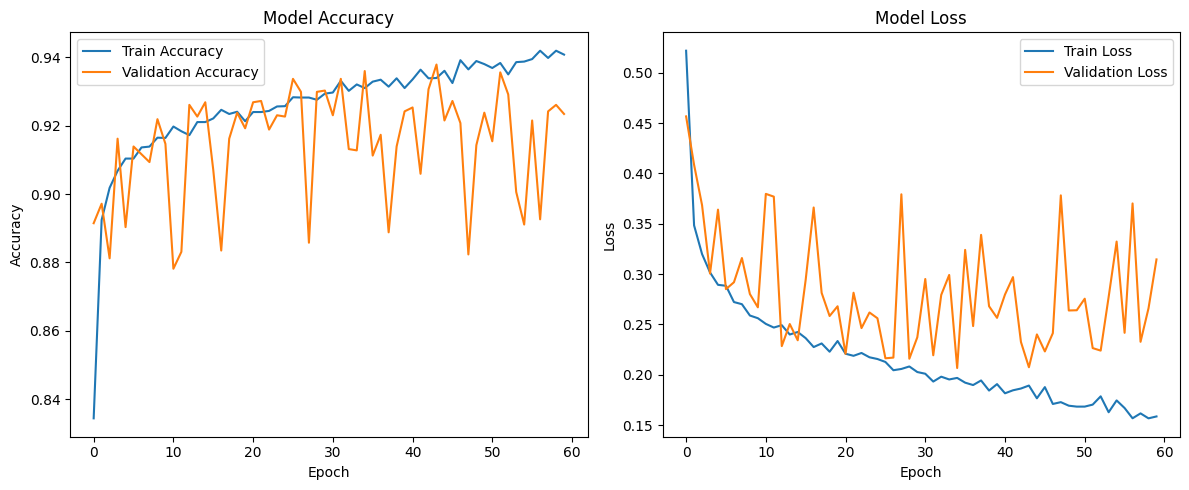

Miglior accuracy: 0.9379 (epoch 44)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.44      0.50      0.47        16
           C       0.90      0.97      0.94      1179
           M       0.97      0.96      0.96        68
        None       0.99      1.00      0.99      1226
           T       0.50      0.14      0.22       137

    accuracy                           0.94      2626
   macro avg       0.76      0.71      0.72      2626
weighted avg       0.92      0.94      0.92      2626



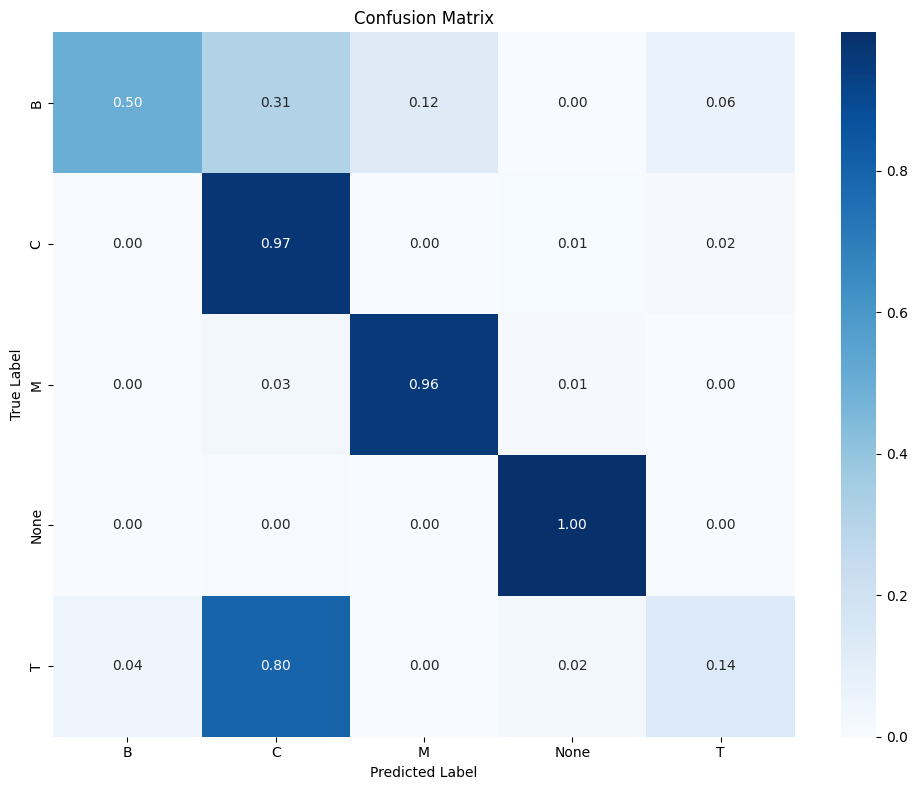


===== TEST RESULTS - MODELLO 19 (SPETTROGRAMMI) =====

===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9196
Test loss: 0.2259
Test accuracy: 0.9196

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.18      0.18      0.18        22
           C       0.88      0.97      0.92      1177
           M       0.96      0.93      0.95        58
        None       0.99      0.99      0.99      1213
           T       0.38      0.08      0.14       156

    accuracy                           0.92      2626
   macro avg       0.68      0.63      0.64      2626
weighted avg       0.90      0.92      0.90      2626



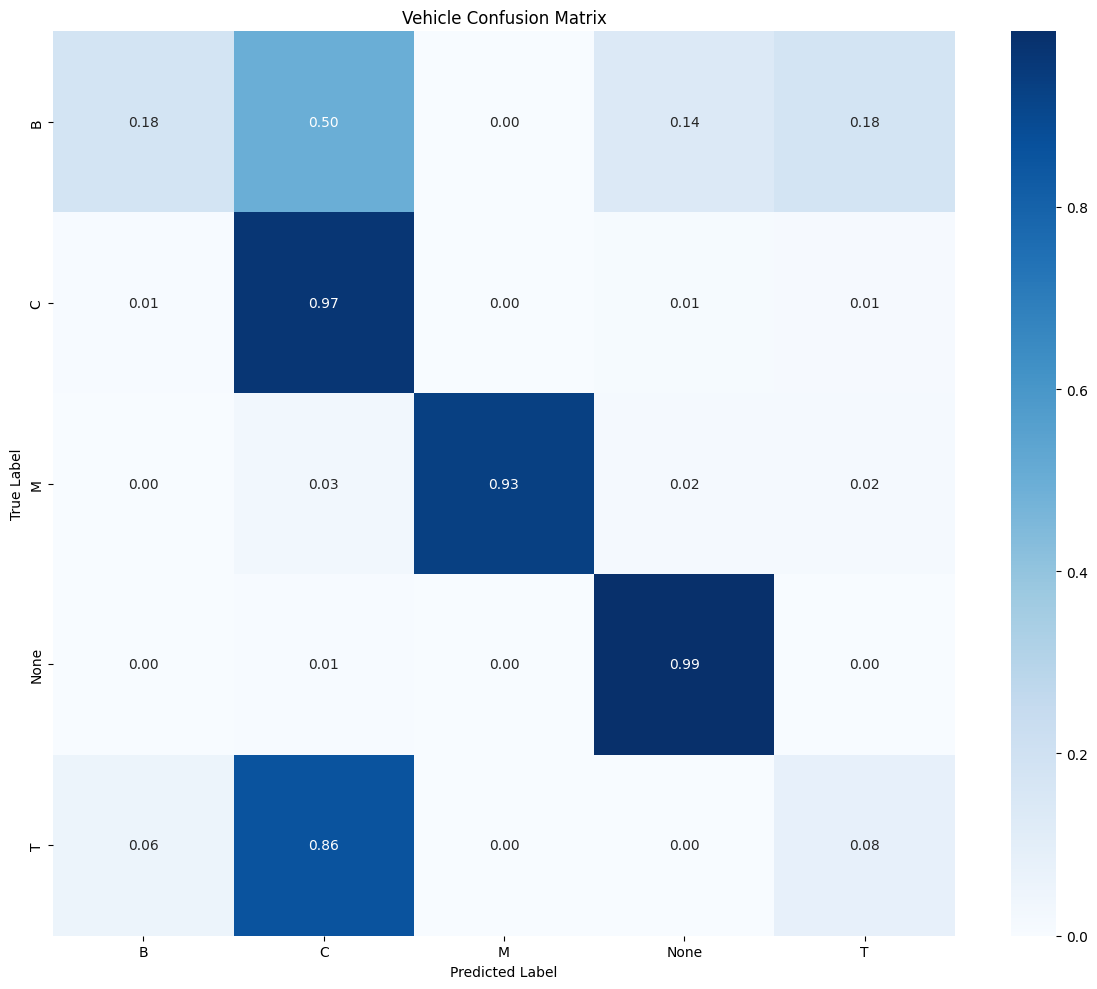


Balanced accuracy score: 0.6315
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 20 (MFCC) =====


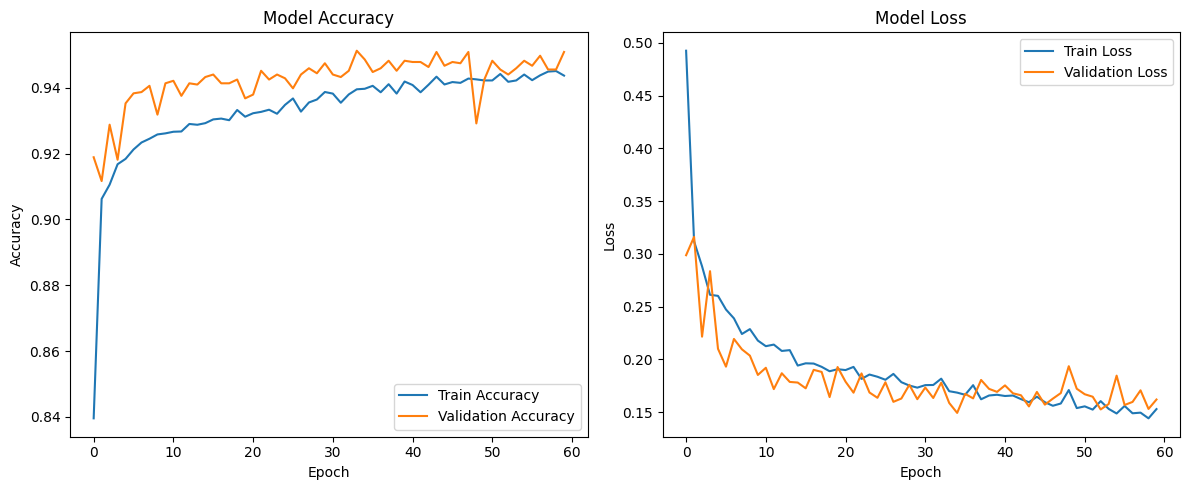

Miglior accuracy: 0.9513 (epoch 34)

--- Classification Report ---
              precision    recall  f1-score   support

           B       0.82      0.56      0.67        16
           C       0.93      0.97      0.95      1179
           M       1.00      0.97      0.99        68
        None       0.99      1.00      1.00      1226
           T       0.58      0.38      0.46       137

    accuracy                           0.95      2626
   macro avg       0.86      0.78      0.81      2626
weighted avg       0.94      0.95      0.94      2626



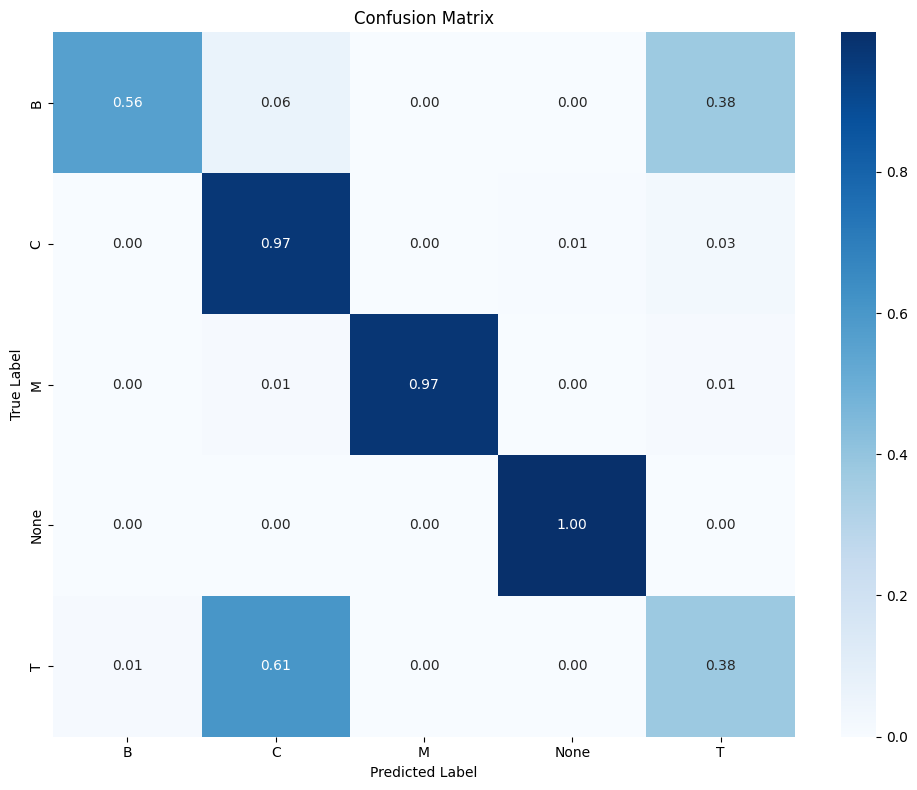


===== TEST RESULTS - MODELLO 20 (MFCC) =====

===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9448
Test loss: 0.1654
Test accuracy: 0.9448

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.73      0.50      0.59        22
           C       0.93      0.96      0.95      1177
           M       0.98      0.97      0.97        58
        None       0.99      0.99      0.99      1213
           T       0.64      0.48      0.55       156

    accuracy                           0.94      2626
   macro avg       0.85      0.78      0.81      2626
weighted avg       0.94      0.94      0.94      2626



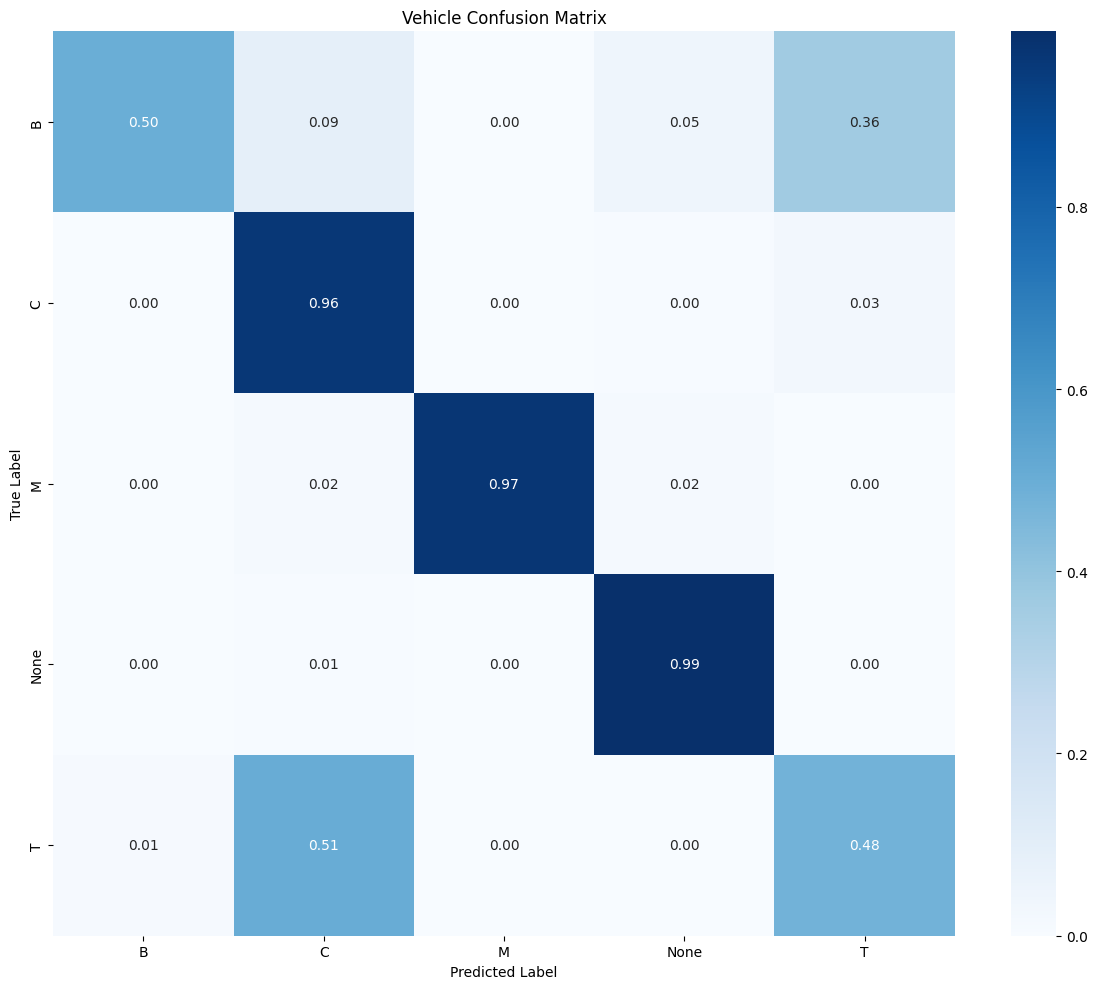


Balanced accuracy score: 0.7806


In [17]:
# Ensure we have class names available
vehicle_class_names = le_vehicle.classes_

# ----- RISULTATI VALIDATION E TEST MODELLO 19 (SPETTROGRAMMI) -----

# Ottieni predizioni sul validation set
val_y_pred_prob_19 = best_model_19.predict([X_val, audio_features_val])
val_y_pred_19 = np.argmax(val_y_pred_prob_19, axis=1)
val_y_true_19 = np.argmax(y_val_vehicle, axis=1)

# Visualizza training history e valutazione validation
print("\n===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 19 (SPETTROGRAMMI) =====")
plot_single_output_model(
    history_19,
    val_y_true_19, val_y_pred_19, vehicle_class_names
)

# Risultati di test (già calcolati)
print("\n===== TEST RESULTS - MODELLO 19 (SPETTROGRAMMI) =====")
plot_vehicle_test_results(
    y_true_19, y_pred_19, vehicle_class_names,
    [test_loss_19, test_acc_19]
)

# ----- RISULTATI VALIDATION E TEST MODELLO 20 (MFCC) -----

# Ottieni predizioni sul validation set
val_y_pred_prob_20 = best_model_20.predict([mfcc_val, audio_features_val])
val_y_pred_20 = np.argmax(val_y_pred_prob_20, axis=1)
val_y_true_20 = np.argmax(y_val_vehicle, axis=1)

# Visualizza training history e valutazione validation
print("\n===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 20 (MFCC) =====")
plot_single_output_model(
    history_20,
    val_y_true_20, val_y_pred_20, vehicle_class_names
)

# Risultati di test (già calcolati)
print("\n===== TEST RESULTS - MODELLO 20 (MFCC) =====")
plot_vehicle_test_results(
    y_true_20, y_pred_20, vehicle_class_names,
    [test_loss_20, test_acc_20]
)

In [18]:
# ------------------------------------------------------------------------------
# MODELLO MONO-OUTPUT - # 21 (con MFCC)
# ------------------------------------------------------------------------------

'''
Versione modificata del modello 17 che usa MFCC al posto degli spettrogrammi
'''

# Definizione del modello

# 1. Ramo CNN per MFCC
input_mfcc = tf.keras.Input(shape=mfccs_reshaped.shape[1:], name='mfcc_input')

x1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_mfcc)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.MaxPooling2D((2, 2))(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.3)(x1)

x1 = tf.keras.layers.Flatten()(x1)


# 2. Ramo per le feature audio
input_features = tf.keras.Input(shape=(audio_features_scaled.shape[1],), name='audio_features_input')

x2 = tf.keras.layers.Dense(64, activation='relu')(input_features)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(64, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.3)(x2)

# Fusione dei due rami
merged = tf.keras.layers.Concatenate()([x1, x2])

# Dense layers finali
x = tf.keras.layers.Dense(1024, activation='relu')(merged)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x_shared = tf.keras.layers.Dense(128, activation='relu')(x)

x_vehicle = tf.keras.layers.Dense(64, activation='relu')(x_shared)
vehicle_output = tf.keras.layers.Dense(5, activation='softmax', name='vehicle_output')(x_vehicle)

# Branch for direction
x_direction = tf.keras.layers.Dense(64, activation='relu')(x_shared)
direction_output = tf.keras.layers.Dense(3, activation='softmax', name='direction_output')(x_direction)

model_21 = tf.keras.Model(
    inputs=[input_mfcc, input_features], 
    outputs=[vehicle_output, direction_output]
)

model_21.summary()


model_21.compile(
    optimizer='adam',
    loss={
        'vehicle_output': 'categorical_crossentropy',
        'direction_output': 'categorical_crossentropy'
    },
    metrics={
        'vehicle_output': ['accuracy'],
        'direction_output': ['accuracy']
    },
    loss_weights={
        'vehicle_output': 2.0, 
        'direction_output': 1.0
    }
)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_vehicle_output_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_21.h5',
    monitor='val_loss',
    save_best_only=True
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 20, 188,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 20, 188,   │      1,216 │ mfcc_input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 10, 94,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 10, 94,    │          0 │ max_pooling2d_21… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 10, 94,    │     36,928 │ dropout_38[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 5, 47, 64) │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 5, 47, 64) │          0 │ max_pooling2d_22… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 5, 47, 32) │     18,464 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_features_inp… │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 2, 23, 32) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │      1,664 │ audio_features_i… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 2, 23, 32) │          0 │ max_pooling2d_23… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 64)        │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 2, 23, 16) │      4,624 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64)        │      4,160 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ conv2d_27[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 64)        │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 16)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                 

 Total params: 726,808 (2.77 MB)

 Trainable params: 726,808 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training del modello 21 (MFCC, multi-output)
history_21 = model_21.fit(
    [mfcc_train, audio_features_train],  # inputs: MFCC e feature audio
    [y_train_vehicle, y_train_direction],  # target: veicolo e direzione
    epochs=150,
    batch_size=32,
    validation_data=([mfcc_val, audio_features_val], [y_val_vehicle, y_val_direction]),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - direction_output_accuracy: 0.6039 - direction_output_loss: 0.7493 - loss: 2.1760 - vehicle_output_accuracy: 0.7491 - vehicle_output_loss: 0.7134

383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - direction_output_accuracy: 0.6043 - direction_output_loss: 0.7485 - loss: 2.1731 - vehicle_output_accuracy: 0.7496 - vehicle_output_loss: 0.7123 - val_direction_output_accuracy: 0.7513 - val_direction_output_loss: 0.4198 - val_loss: 0.9695 - val_vehicle_output_accuracy: 0.9139 - val_vehicle_output_loss: 0.2755 - learning_rate: 0.0010
Epoch 2/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - direction_output_accuracy: 0.7206 - direction_output_loss: 0.4409 - loss: 1.1009 - vehicle_output_accuracy: 0.8970 - vehicle_output_loss: 0.3300

383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - direction_output_accuracy: 0.7206 - direction_output_loss: 0.4409 - loss: 1.1008 - vehicle_output_accuracy: 0.8970 - vehicle_output_loss: 0.3300 - val_direction_output_accuracy: 0.7570 - val_direction_output_loss: 0.4000 - val_loss: 0.9013 - val_vehicle_output_accuracy: 0.9269 - val_vehicle_output_loss: 0.2517 - learning_rate: 0.0010
Epoch 3/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - direction_output_accuracy: 0.7299 - direction_output_loss: 0.4253 - loss: 1.0093 - vehicle_output_accuracy: 0.9061 - vehicle_output_loss: 0.2920

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - direction_output_accuracy: 0.7299 - direction_output_loss: 0.4253 - loss: 1.0093 - vehicle_output_accuracy: 0.9061 - vehicle_output_loss: 0.2920 - val_direction_output_accuracy: 0.7376 - val_direction_output_loss: 0.3985 - val_loss: 0.8517 - val_vehicle_output_accuracy: 0.9284 - val_vehicle_output_loss: 0.2275 - learning_rate: 0.0010
Epoch 4/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - direction_output_accuracy: 0.7300 - direction_output_loss: 0.4175 - loss: 0.9721 - vehicle_output_accuracy: 0.9127 - vehicle_output_loss: 0.2773 - val_direction_output_accuracy: 0.7372 - val_direction_output_loss: 0.4014 - val_loss: 0.8635 - val_vehicle_output_accuracy: 0.9303 - val_vehicle_output_loss: 0.2322 - learning_rate: 0.0010
Epoch 5/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - direction_output_accuracy: 0.7311 - direction_output_loss: 0.4105 - loss: 0.9083 - vehicle_output_accuracy: 0.9204 - vehicle_output_loss: 0.2489

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - direction_output_accuracy: 0.7311 - direction_output_loss: 0.4105 - loss: 0.9083 - vehicle_output_accuracy: 0.9204 - vehicle_output_loss: 0.2489 - val_direction_output_accuracy: 0.7414 - val_direction_output_loss: 0.3918 - val_loss: 0.8005 - val_vehicle_output_accuracy: 0.9315 - val_vehicle_output_loss: 0.2053 - learning_rate: 0.0010
Epoch 6/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - direction_output_accuracy: 0.7366 - direction_output_loss: 0.4031 - loss: 0.8884 - vehicle_output_accuracy: 0.9180 - vehicle_output_loss: 0.2426

383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - direction_output_accuracy: 0.7366 - direction_output_loss: 0.4031 - loss: 0.8884 - vehicle_output_accuracy: 0.9180 - vehicle_output_loss: 0.2426 - val_direction_output_accuracy: 0.7193 - val_direction_output_loss: 0.4020 - val_loss: 0.7939 - val_vehicle_output_accuracy: 0.9315 - val_vehicle_output_loss: 0.1963 - learning_rate: 0.0010
Epoch 7/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.7381 - direction_output_loss: 0.4102 - loss: 0.9232 - vehicle_output_accuracy: 0.9161 - vehicle_output_loss: 0.2565 - val_direction_output_accuracy: 0.7681 - val_direction_output_loss: 0.4176 - val_loss: 0.8892 - val_vehicle_output_accuracy: 0.9383 - val_vehicle_output_loss: 0.2365 - learning_rate: 0.0010
Epoch 8/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - direction_output_accuracy: 0.7564 - direction_output_loss: 0.4047 - loss: 0.8836 - vehicle_output_accuracy: 0.9202 - vehicle_output_loss: 0.2395 - val_direction_output_a

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.7781 - direction_output_loss: 0.4011 - loss: 0.8748 - vehicle_output_accuracy: 0.9211 - vehicle_output_loss: 0.2368 - val_direction_output_accuracy: 0.8149 - val_direction_output_loss: 0.3434 - val_loss: 0.7025 - val_vehicle_output_accuracy: 0.9406 - val_vehicle_output_loss: 0.1790 - learning_rate: 0.0010
Epoch 12/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.7940 - direction_output_loss: 0.3742 - loss: 0.8163 - vehicle_output_accuracy: 0.9251 - vehicle_output_loss: 0.2211 - val_direction_output_accuracy: 0.8126 - val_direction_output_loss: 0.3521 - val_loss: 0.7447 - val_vehicle_output_accuracy: 0.9349 - val_vehicle_output_loss: 0.1955 - learning_rate: 0.0010
Epoch 13/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.8094 - direction_output_loss: 0.3600 - loss: 0.7927 - vehicle_output_accuracy: 0.9262 - vehicle_output_loss: 0.2163 - val_direction_output

383/383 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - direction_output_accuracy: 0.8535 - direction_output_loss: 0.3002 - loss: 0.7215 - vehicle_output_accuracy: 0.9283 - vehicle_output_loss: 0.2107 - val_direction_output_accuracy: 0.8869 - val_direction_output_loss: 0.2704 - val_loss: 0.7000 - val_vehicle_output_accuracy: 0.9364 - val_vehicle_output_loss: 0.2141 - learning_rate: 0.0010
Epoch 18/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - direction_output_accuracy: 0.8647 - direction_output_loss: 0.2760 - loss: 0.6710 - vehicle_output_accuracy: 0.9342 - vehicle_output_loss: 0.1975

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.8647 - direction_output_loss: 0.2760 - loss: 0.6710 - vehicle_output_accuracy: 0.9342 - vehicle_output_loss: 0.1975 - val_direction_output_accuracy: 0.8907 - val_direction_output_loss: 0.2635 - val_loss: 0.6837 - val_vehicle_output_accuracy: 0.9410 - val_vehicle_output_loss: 0.2093 - learning_rate: 0.0010
Epoch 19/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.8794 - direction_output_loss: 0.2562 - loss: 0.6621 - vehicle_output_accuracy: 0.9318 - vehicle_output_loss: 0.2029 - val_direction_output_accuracy: 0.9063 - val_direction_output_loss: 0.2388 - val_loss: 0.6840 - val_vehicle_output_accuracy: 0.9337 - val_vehicle_output_loss: 0.2217 - learning_rate: 0.0010
Epoch 20/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - direction_output_accuracy: 0.8993 - direction_output_loss: 0.2272 - loss: 0.6438 - vehicle_output_accuracy: 0.9304 - vehicle_output_loss: 0.2083

383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - direction_output_accuracy: 0.8993 - direction_output_loss: 0.2272 - loss: 0.6438 - vehicle_output_accuracy: 0.9304 - vehicle_output_loss: 0.2083 - val_direction_output_accuracy: 0.9227 - val_direction_output_loss: 0.2093 - val_loss: 0.6437 - val_vehicle_output_accuracy: 0.9368 - val_vehicle_output_loss: 0.2166 - learning_rate: 5.0000e-04
Epoch 21/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - direction_output_accuracy: 0.9023 - direction_output_loss: 0.2184 - loss: 0.6087 - vehicle_output_accuracy: 0.9301 - vehicle_output_loss: 0.1951 - val_direction_output_accuracy: 0.9132 - val_direction_output_loss: 0.2158 - val_loss: 0.6572 - val_vehicle_output_accuracy: 0.9322 - val_vehicle_output_loss: 0.2201 - learning_rate: 5.0000e-04
Epoch 22/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - direction_output_accuracy: 0.9100 - direction_output_loss: 0.1977 - loss: 0.5855 - vehicle_output_accuracy: 0.9348 - vehicle_output_loss: 0.1939

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.9100 - direction_output_loss: 0.1977 - loss: 0.5854 - vehicle_output_accuracy: 0.9348 - vehicle_output_loss: 0.1939 - val_direction_output_accuracy: 0.9128 - val_direction_output_loss: 0.2052 - val_loss: 0.6300 - val_vehicle_output_accuracy: 0.9315 - val_vehicle_output_loss: 0.2133 - learning_rate: 5.0000e-04
Epoch 23/150
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - direction_output_accuracy: 0.9169 - direction_output_loss: 0.1825 - loss: 0.5390 - vehicle_output_accuracy: 0.9371 - vehicle_output_loss: 0.1782

383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.9169 - direction_output_loss: 0.1825 - loss: 0.5391 - vehicle_output_accuracy: 0.9370 - vehicle_output_loss: 0.1783 - val_direction_output_accuracy: 0.9181 - val_direction_output_loss: 0.1974 - val_loss: 0.6159 - val_vehicle_output_accuracy: 0.9421 - val_vehicle_output_loss: 0.2087 - learning_rate: 5.0000e-04
Epoch 24/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.9185 - direction_output_loss: 0.1878 - loss: 0.5559 - vehicle_output_accuracy: 0.9376 - vehicle_output_loss: 0.1840 - val_direction_output_accuracy: 0.9269 - val_direction_output_loss: 0.1884 - val_loss: 0.6175 - val_vehicle_output_accuracy: 0.9421 - val_vehicle_output_loss: 0.2140 - learning_rate: 5.0000e-04
Epoch 25/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - direction_output_accuracy: 0.9202 - direction_output_loss: 0.1751 - loss: 0.5452 - vehicle_output_accuracy: 0.9338 - vehicle_output_loss: 0.1851

383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.9202 - direction_output_loss: 0.1751 - loss: 0.5453 - vehicle_output_accuracy: 0.9338 - vehicle_output_loss: 0.1851 - val_direction_output_accuracy: 0.9330 - val_direction_output_loss: 0.1742 - val_loss: 0.5885 - val_vehicle_output_accuracy: 0.9322 - val_vehicle_output_loss: 0.2073 - learning_rate: 5.0000e-04
Epoch 26/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.9239 - direction_output_loss: 0.1721 - loss: 0.5170 - vehicle_output_accuracy: 0.9412 - vehicle_output_loss: 0.1724 - val_direction_output_accuracy: 0.9402 - val_direction_output_loss: 0.1662 - val_loss: 0.6119 - val_vehicle_output_accuracy: 0.9326 - val_vehicle_output_loss: 0.2218 - learning_rate: 5.0000e-04
Epoch 27/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - direction_output_accuracy: 0.9274 - direction_output_loss: 0.1658 - loss: 0.5053 - vehicle_output_accuracy: 0.9399 - vehicle_output_loss: 0.1697

383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.9274 - direction_output_loss: 0.1658 - loss: 0.5053 - vehicle_output_accuracy: 0.9399 - vehicle_output_loss: 0.1698 - val_direction_output_accuracy: 0.9425 - val_direction_output_loss: 0.1428 - val_loss: 0.5620 - val_vehicle_output_accuracy: 0.9406 - val_vehicle_output_loss: 0.2084 - learning_rate: 5.0000e-04
Epoch 28/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - direction_output_accuracy: 0.9356 - direction_output_loss: 0.1481 - loss: 0.5018 - vehicle_output_accuracy: 0.9365 - vehicle_output_loss: 0.1768

383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.9356 - direction_output_loss: 0.1481 - loss: 0.5018 - vehicle_output_accuracy: 0.9365 - vehicle_output_loss: 0.1768 - val_direction_output_accuracy: 0.9459 - val_direction_output_loss: 0.1445 - val_loss: 0.5415 - val_vehicle_output_accuracy: 0.9379 - val_vehicle_output_loss: 0.1980 - learning_rate: 2.5000e-04
Epoch 29/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - direction_output_accuracy: 0.9386 - direction_output_loss: 0.1444 - loss: 0.4842 - vehicle_output_accuracy: 0.9370 - vehicle_output_loss: 0.1699 - val_direction_output_accuracy: 0.9471 - val_direction_output_loss: 0.1400 - val_loss: 0.6665 - val_vehicle_output_accuracy: 0.8979 - val_vehicle_output_loss: 0.2636 - learning_rate: 2.5000e-04
Epoch 30/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - direction_output_accuracy: 0.9388 - direction_output_loss: 0.1349 - loss: 0.4811 - vehicle_output_accuracy: 0.9392 - vehicle_output_loss: 0.1731

383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - direction_output_accuracy: 0.9389 - direction_output_loss: 0.1349 - loss: 0.4811 - vehicle_output_accuracy: 0.9392 - vehicle_output_loss: 0.1731 - val_direction_output_accuracy: 0.9448 - val_direction_output_loss: 0.1382 - val_loss: 0.5321 - val_vehicle_output_accuracy: 0.9383 - val_vehicle_output_loss: 0.1966 - learning_rate: 2.5000e-04
Epoch 31/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - direction_output_accuracy: 0.9379 - direction_output_loss: 0.1435 - loss: 0.4714 - vehicle_output_accuracy: 0.9432 - vehicle_output_loss: 0.1640 - val_direction_output_accuracy: 0.9440 - val_direction_output_loss: 0.1383 - val_loss: 0.6163 - val_vehicle_output_accuracy: 0.9155 - val_vehicle_output_loss: 0.2388 - learning_rate: 2.5000e-04
Epoch 32/150
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - direction_output_accuracy: 0.9356 - direction_output_loss: 0.1380 - loss: 0.4764 - vehicle_output_accuracy: 0.9420 - vehicle_output_loss: 0.1692 - val_directio

In [20]:
# TEST modello 21 (MFCC, multi-output)
best_model_21 = tf.keras.models.load_model('best_model_21.h5')

# Valutazione completa del modello
test_results = model_21.evaluate(
    [mfcc_test, audio_features_test], 
    [y_test_vehicle, y_test_direction], 
    verbose=1
)
print(f"\nTest loss totale (modello 21): {test_results[0]:.4f}")
print(f"Test vehicle loss (modello 21): {test_results[1]:.4f}")
print(f"Test direction loss (modello 21): {test_results[2]:.4f}")
print(f"Test vehicle accuracy (modello 21): {test_results[3]:.4f}")
print(f"Test direction accuracy (modello 21): {test_results[4]:.4f}")

# Predizioni
y_pred_21 = model_21.predict([mfcc_test, audio_features_test])
y_pred_vehicle_21 = np.argmax(y_pred_21[0], axis=1)  # Primo output: veicolo
y_pred_direction_21 = np.argmax(y_pred_21[1], axis=1)  # Secondo output: direzione

y_true_vehicle_21 = np.argmax(y_test_vehicle, axis=1)
y_true_direction_21 = np.argmax(y_test_direction, axis=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - direction_output_accuracy: 0.9467 - direction_output_loss: 0.1448 - loss: 0.5396 - vehicle_output_accuracy: 0.9330 - vehicle_output_loss: 0.1974

Test loss totale (modello 21): 0.5377
Test vehicle loss (modello 21): 0.1981
Test direction loss (modello 21): 0.1411
Test vehicle accuracy (modello 21): 0.9478
Test direction accuracy (modello 21): 0.9318
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 21 (MFCC, MULTI-OUTPUT) =====


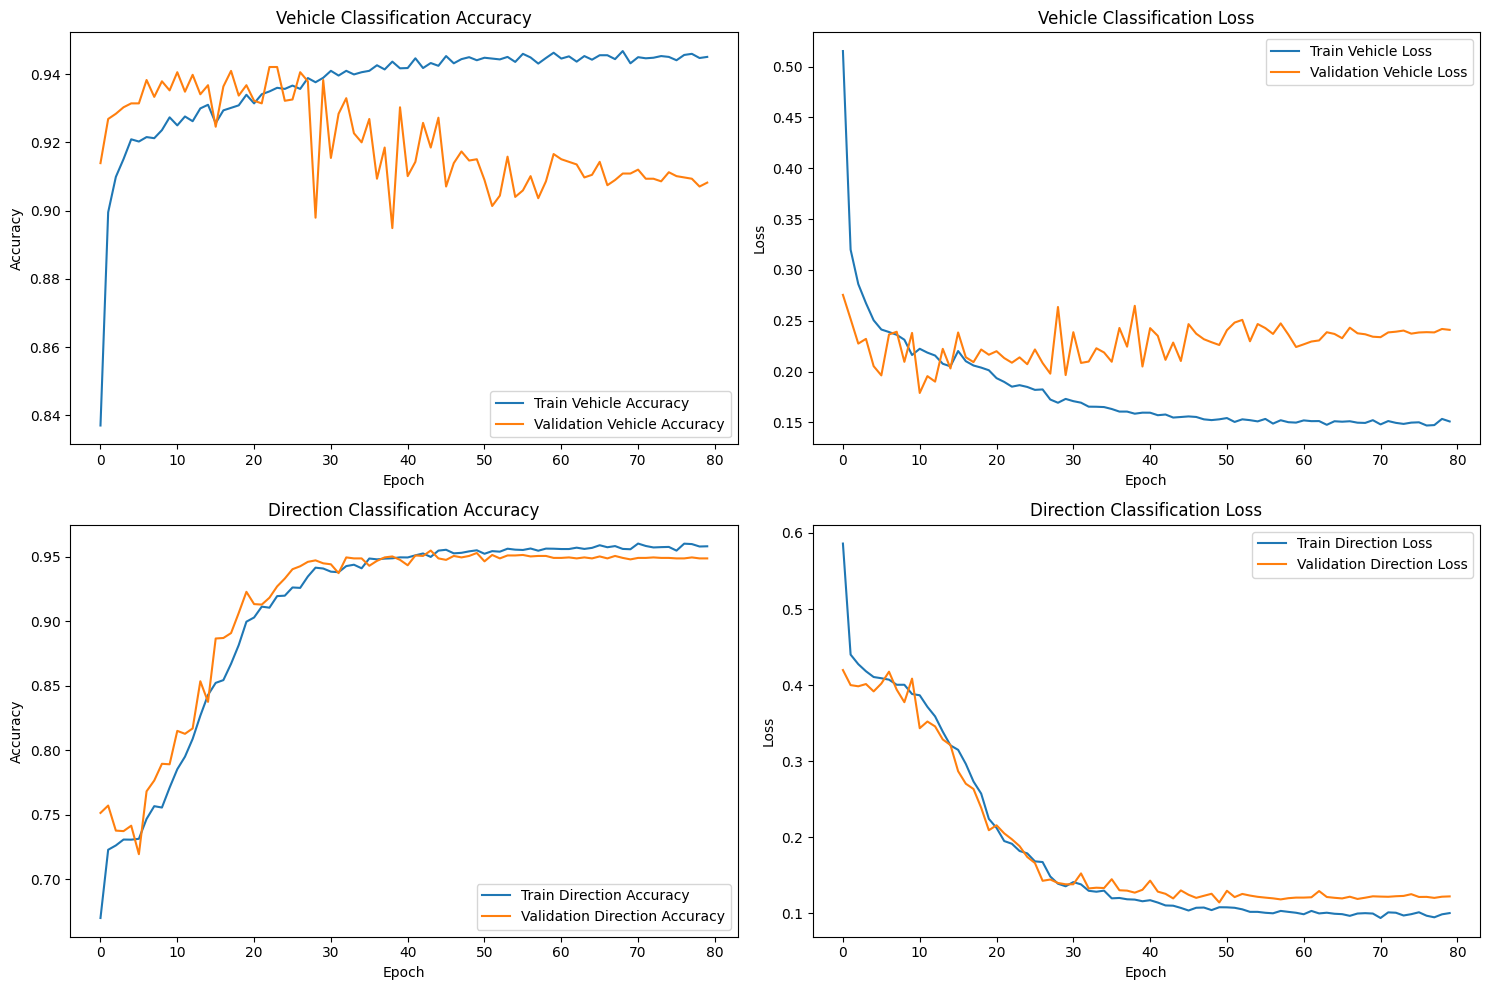


===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Miglior vehicle accuracy: 0.9421 (epoch 23)

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.36      0.56      0.44        16
           C       0.92      0.96      0.94      1179
           M       0.97      0.97      0.97        68
        None       0.99      0.99      0.99      1226
           T       0.45      0.26      0.33       137

    accuracy                           0.94      2626
   macro avg       0.74      0.75      0.73      2626
weighted avg       0.93      0.94      0.93      2626



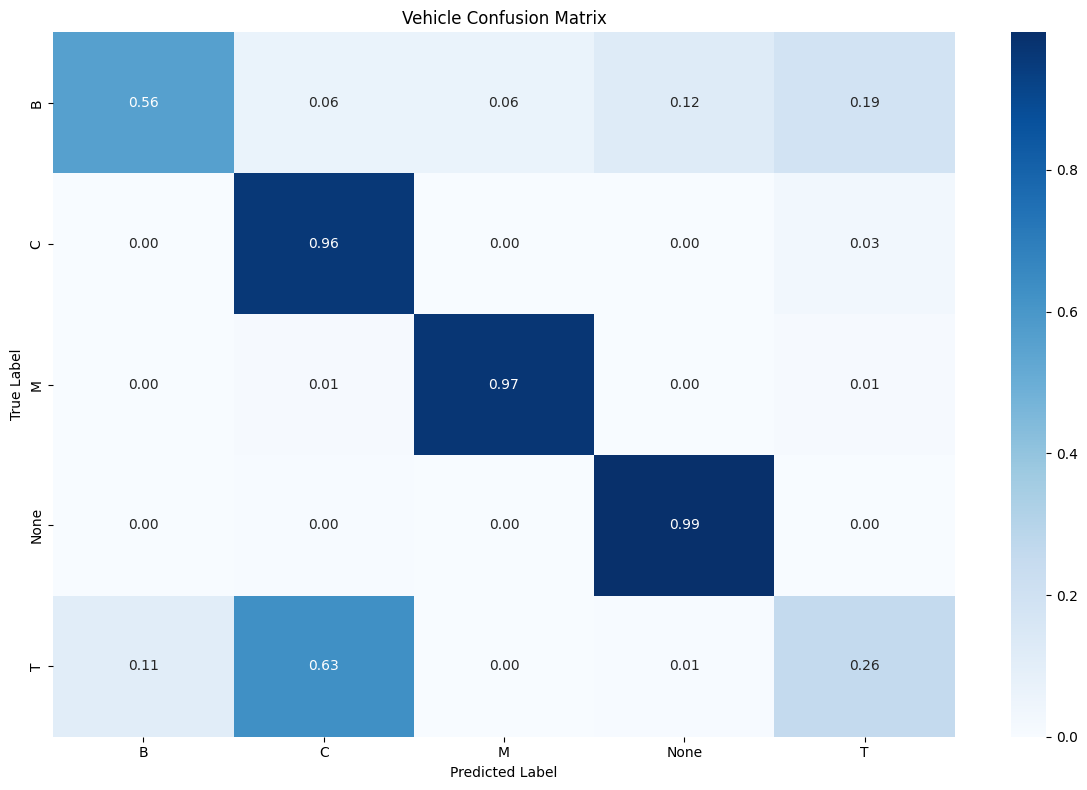


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Miglior direction accuracy: 0.9547 (epoch 44)

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.85      0.96      0.90       676
        None       0.99      0.99      0.99      1226
           R       0.97      0.84      0.90       724

    accuracy                           0.94      2626
   macro avg       0.94      0.93      0.93      2626
weighted avg       0.95      0.94      0.94      2626



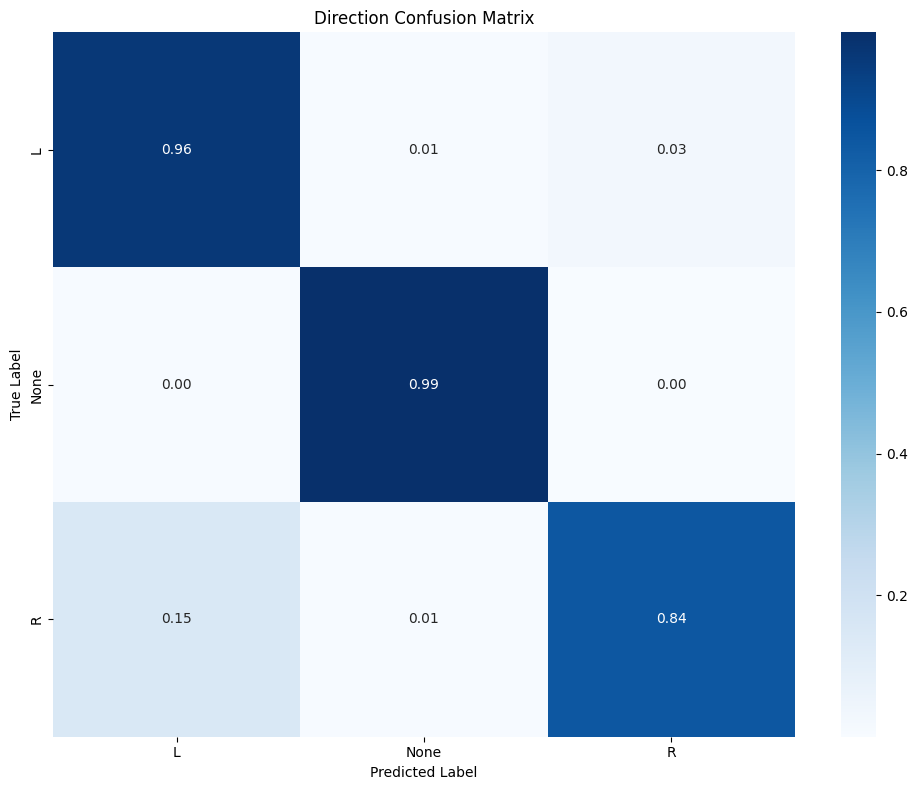


===== TEST RESULTS - MODELLO 21 (MFCC, MULTI-OUTPUT) =====

===== RISULTATI CLASSIFICAZIONE VEICOLI =====
Vehicle accuracy: 0.9318
Vehicle loss: 0.1981

--- Vehicle Classification Report ---
              precision    recall  f1-score   support

           B       0.45      0.68      0.55        22
           C       0.91      0.96      0.94      1177
           M       0.93      0.97      0.95        58
        None       1.00      0.99      0.99      1213
           T       0.49      0.31      0.38       156

    accuracy                           0.93      2626
   macro avg       0.76      0.78      0.76      2626
weighted avg       0.92      0.93      0.93      2626



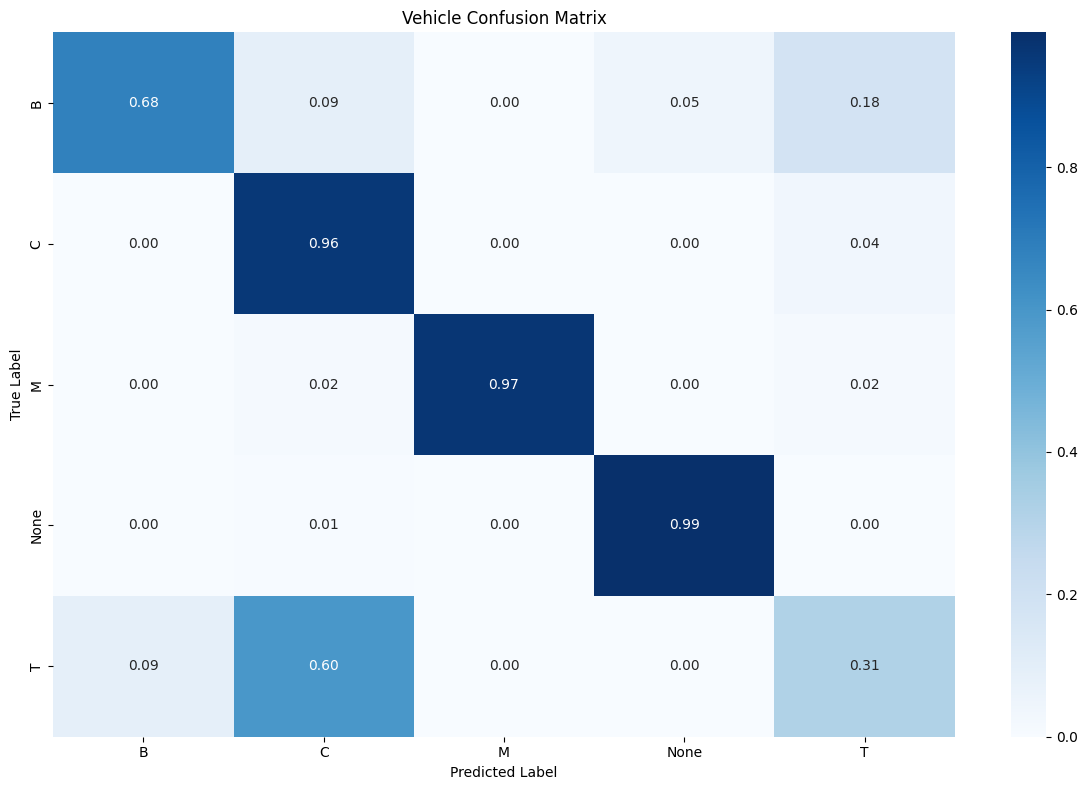


===== RISULTATI CLASSIFICAZIONE DIREZIONE =====
Direction accuracy: 0.9478
Direction loss: 0.1411

--- Direction Classification Report ---
              precision    recall  f1-score   support

           L       0.87      0.96      0.91       715
        None       1.00      0.99      0.99      1213
           R       0.95      0.86      0.91       698

    accuracy                           0.95      2626
   macro avg       0.94      0.94      0.94      2626
weighted avg       0.95      0.95      0.95      2626



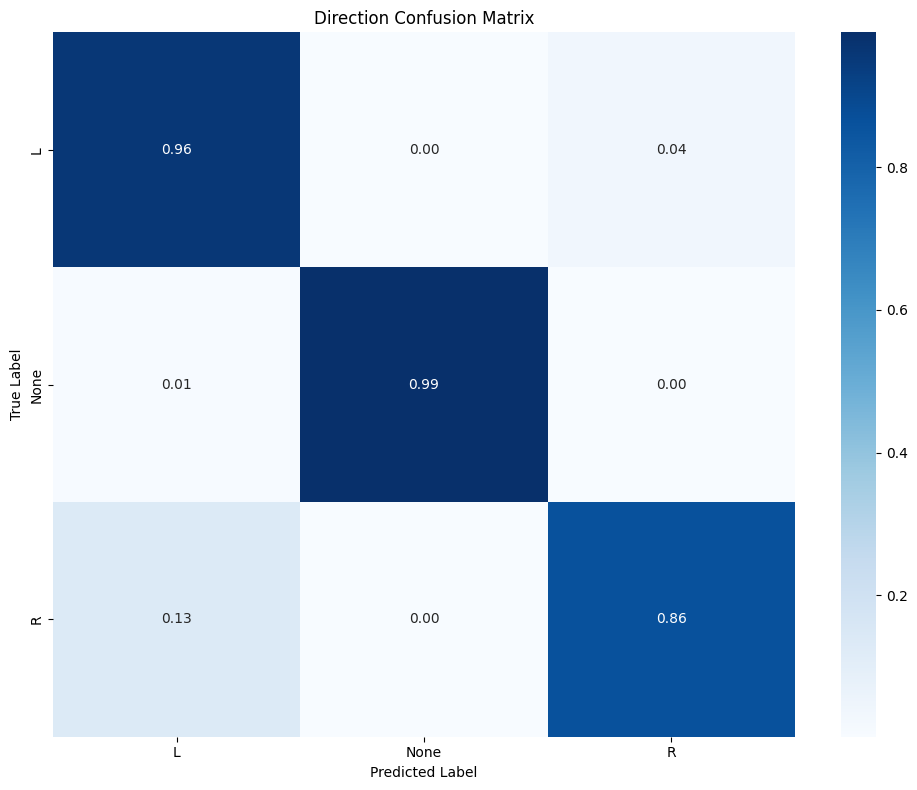

In [21]:
# Ensure we have class names available
vehicle_class_names = le_vehicle.classes_
direction_class_names = le_direction.classes_

# ----- RISULTATI VALIDATION E TEST MODELLO 21 (MFCC, MULTI-OUTPUT) -----

# Ottieni predizioni sul validation set
val_pred_21 = model_21.predict([mfcc_val, audio_features_val])
val_pred_vehicle_21 = np.argmax(val_pred_21[0], axis=1)
val_pred_direction_21 = np.argmax(val_pred_21[1], axis=1)
val_true_vehicle_21 = np.argmax(y_val_vehicle, axis=1)
val_true_direction_21 = np.argmax(y_val_direction, axis=1)

# Visualizza training history e valutazione validation
print("\n===== TRAINING HISTORY AND VALIDATION PREDICTION - MODELLO 21 (MFCC, MULTI-OUTPUT) =====")
plot_and_evaluate_multi_output_model(
    history_21,
    val_true_vehicle_21, val_pred_vehicle_21, vehicle_class_names,
    val_true_direction_21, val_pred_direction_21, direction_class_names
)

# Risultati di test (già calcolati)
print("\n===== TEST RESULTS - MODELLO 21 (MFCC, MULTI-OUTPUT) =====")
plot_test_results_multi_output_model(
    y_true_vehicle_21, y_pred_vehicle_21, vehicle_class_names,
    y_true_direction_21, y_pred_direction_21, direction_class_names,
    test_results
)